# Introduction

QA plots for the single particle in calorimeters and reconstructed as calorimetric jet objects

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

In [3]:
# initialization

display(Markdown('pyROOT env check:'))

import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

pyROOT env check:

Welcome to JupyROOT 6.22/02


via sPHENIX software distribution at `/var/lib/jenkins/workspace/sPHENIX/Build-Master-gcc8/build/new/install.1`

In [4]:
import subprocess

try:
    git_url = \
        subprocess.run(['git','remote','get-url','origin'], stdout=subprocess.PIPE)\
        .stdout.decode('utf-8').strip()\
        .replace('git@github.com:','https://github.com/')

    display(Markdown(f"View the source code repository at {git_url}"))
except: # catch *all* exceptions
    #     well do nothing
    pass


View the source code repository at https://github.com/sPHENIX-Collaboration/QA-gallery.git

In [5]:
display(Markdown('Some further details about the QA run, if executed under the Jenkins CI:'))

checkrun_repo_commit = os.getenv("checkrun_repo_commit")
if checkrun_repo_commit is not None:
    display(Markdown(f"* The commit being checked is {checkrun_repo_commit}"))
        
ghprbPullLink = os.getenv("ghprbPullLink")
if ghprbPullLink is not None:
    display(Markdown(f"* Link to the pull request: {ghprbPullLink}"))

BUILD_URL =  os.getenv("BUILD_URL")
if BUILD_URL is not None:
    display(Markdown(f"* Link to the build: {BUILD_URL}"))

RUN_ARTIFACTS_DISPLAY_URL = os.getenv("RUN_ARTIFACTS_DISPLAY_URL")
if RUN_ARTIFACTS_DISPLAY_URL is not None:
    display(Markdown(f"* Download the QA ROOT files: {RUN_ARTIFACTS_DISPLAY_URL}"))

JENKINS_URL  = os.getenv("JENKINS_URL")
if JENKINS_URL is not None:
    display(Markdown(f"Automatically generated by [sPHENIX Jenkins continuous integration]({JENKINS_URL}) [![sPHENIX](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/sphenix-logo-white-bg-72p.png)](https://www.sphenix.bnl.gov/web/) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [![jenkins.io](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/jenkins_logo_title-72p.png)](https://jenkins.io/)"))

Some further details about the QA run, if executed under the Jenkins CI:

* The commit being checked is sPHENIX-Collaboration/coresoftware/5c5d28ff608b63a4a9246cf7df47a791e8996a77

* Link to the pull request: https://github.com/sPHENIX-Collaboration/coresoftware/pull/1266

* Link to the build: https://web.sdcc.bnl.gov/jenkins-sphenix/job/sPHENIX/job/test-calo-single-qa/2434/

* Download the QA ROOT files: https://web.sdcc.bnl.gov/jenkins-sphenix/job/sPHENIX/job/test-calo-single-qa/2434/display/redirect?page=artifacts

Automatically generated by [sPHENIX Jenkins continuous integration](https://web.sdcc.bnl.gov/jenkins-sphenix/) [![sPHENIX](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/sphenix-logo-white-bg-72p.png)](https://www.sphenix.bnl.gov/web/) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [![jenkins.io](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/jenkins_logo_title-72p.png)](https://jenkins.io/)


# Initialization

In [6]:
%%cpp -d

#include "QA_Draw_Utility.C"

#include <sPhenixStyle.C>

#include <TFile.h>
#include <TLine.h>
#include <TString.h>
#include <TTree.h>
#include <cassert>
#include <cmath>

In [7]:
%%cpp

SetsPhenixStyle();
TVirtualFitter::SetDefaultFitter("Minuit2");

// test sPHENIX lib load
// gSystem->Load("libg4eval.so");

// test libs
// gSystem->ListLibraries();

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


## Inputs and file checks

In [8]:

qa_file_name_new = os.getenv("qa_file_name_new")
if qa_file_name_new is None:
    qa_file_name_new = "G4sPHENIX_pi+_pT30_Sum15_qa.root"
    display(Markdown(f"`qa_file_name_new` env not set. use the default `qa_file_name_new={qa_file_name_new}`"))

qa_file_name_ref = os.getenv("qa_file_name_ref")
if qa_file_name_ref is None:
    qa_file_name_ref = "reference/G4sPHENIX_pi+_pT30_Sum15_qa.root"
    display(Markdown(f"`qa_file_name_ref` env not set. use the default `qa_file_name_ref={qa_file_name_ref}`"))
elif qa_file_name_ref == 'None':
    qa_file_name_ref = None
    display(Markdown(f"`qa_file_name_ref` = None and we are set to not to use the reference histograms"))
    


In [9]:
# qa_file_new = ROOT.TFile.Open(qa_file_name_new);

# assert qa_file_new.IsOpen()
# qa_file_new.ls()
display(Markdown(f"Openning QA file at `{qa_file_name_new}`"))
ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_new = new TFile(\"{qa_file_name_new}\");")
ROOT.gInterpreter.ProcessLine(f"const char * qa_file_name_new = \"{qa_file_name_new}\";")

if qa_file_name_ref is not None:
#     qa_file_ref = ROOT.TFile.Open(qa_file_name_ref);

#     assert qa_file_ref.IsOpen()
    display(Markdown(f"Openning QA reference file at `{qa_file_name_ref}`"))
    ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_ref = new TFile(\"{qa_file_name_ref}\");")
    ROOT.gInterpreter.ProcessLine(f"const char *  qa_file_name_ref = \"{qa_file_name_ref}\";")
else:
    ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_ref = nullptr;")
    ROOT.gInterpreter.ProcessLine(f"const char *  qa_file_name_ref = nullptr;")


Openning QA file at `G4sPHENIX_pi+_pT30_Sum8_qa.root`

Openning QA reference file at `reference/G4sPHENIX_pi+_pT30_Sum8_qa.root`

In [10]:
%%cpp

if (qa_file_new == nullptr) 
{
    cout <<"Error, can not open QA root file"<<qa_file_name_new<<endl;
    exit(1);
}

// list inputs histograms if needed
// qa_file_new ->ls();

//TFile *qa_file_ref = NULL;
//if (qa_file_name_ref)
//{
//    qa_file_ref = new TFile(qa_file_name_ref);
//  
//    if (qa_file_ref == nullptr) 
//    {
//        cout <<"Error, can not open QA root file"<<qa_file_name_ref<<endl;
//        exit(1);
//    }
//}

In [11]:
%%cpp -d

// Jet utility functions


void QA_Draw_Jet_Spectrum(
    const char *jet = "h_QAG4SimJet_AntiKt_Truth_r07")
{

  // obtain normalization
  double Nevent_new = 1;
  double Nevent_ref = 1;

  if (qa_file_new)
  {
    TH1D *h_norm = (TH1D *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Normalization"), "TH1D");
    assert(h_norm);

    Nevent_new = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin("Event"));
  }
  if (qa_file_ref)
  {
    TH1D *h_norm = (TH1D *) qa_file_ref->GetObjectChecked(
        TString(jet) + TString("_Normalization"), "TH1D");
    assert(h_norm);

    Nevent_ref = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin("Event"));
  }

  TCanvas *c1 = new TCanvas(TString("QA_Draw_Jet_Spectrum_") + TString(jet),
                            TString("QA_Draw_Jet_Spectrum_") + TString(jet), 1800, 1000);
  c1->Divide(4, 2);
  int idx = 1;
  TPad *p;

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_eta"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_eta"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_phi"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_phi"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_Et"), "TH1F");
    assert(h_new);

    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_Et"), "TH1F");
      assert(h_ref);

      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_Mass"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_Mass"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogx();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_CompSize"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_CompSize"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_CEMC_Ratio"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_CEMC_Ratio"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_CEMC_HCalIN_Ratio"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_CEMC_HCalIN_Ratio"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  if (TString(jet).Contains("Truth"))
  {
    // truth jets

    p = (TPad *) c1->cd(idx++);
    c1->Update();
    p->SetLogy();

    {
      TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
          TString(jet) + TString("_Leading_Leakage_Ratio"), "TH1F");
      assert(h_new);

      h_new->Rebin(2);
      // h_new->Sumw2();
      h_new->Scale(1. / Nevent_new);

      TH1F *h_ref = NULL;
      if (qa_file_ref)
      {
        h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
            TString(jet) + TString("_Leading_Leakage_Ratio"), "TH1F");
        assert(h_ref);

        h_ref->Rebin(2);
        h_ref->Scale(1. / Nevent_ref);
      }

      h_new->GetYaxis()->SetTitleOffset(1.5);
      h_new->GetYaxis()->SetTitle("Count / event / bin");
      //      h_new->GetXaxis()->SetRangeUser(-0, .1);

      DrawReference(h_new, h_ref);
    }
  }

//  PutInputFileName(c1, .04, qa_file_name_new, qa_file_name_ref);
    c1->Draw();
    
    //  SaveCanvas(c1, TString(qa_file_name_new) + TString(c1->GetName()), false);
    
}


# $R=0.7$ Jets spectrums

Check the particular set of jets with $R=0.7$ parameters

## Truth jet spectrum

Jet the details of the truth jet. Since only one particle is used in this simulation, the number of component is 1 and jet mass is 0.

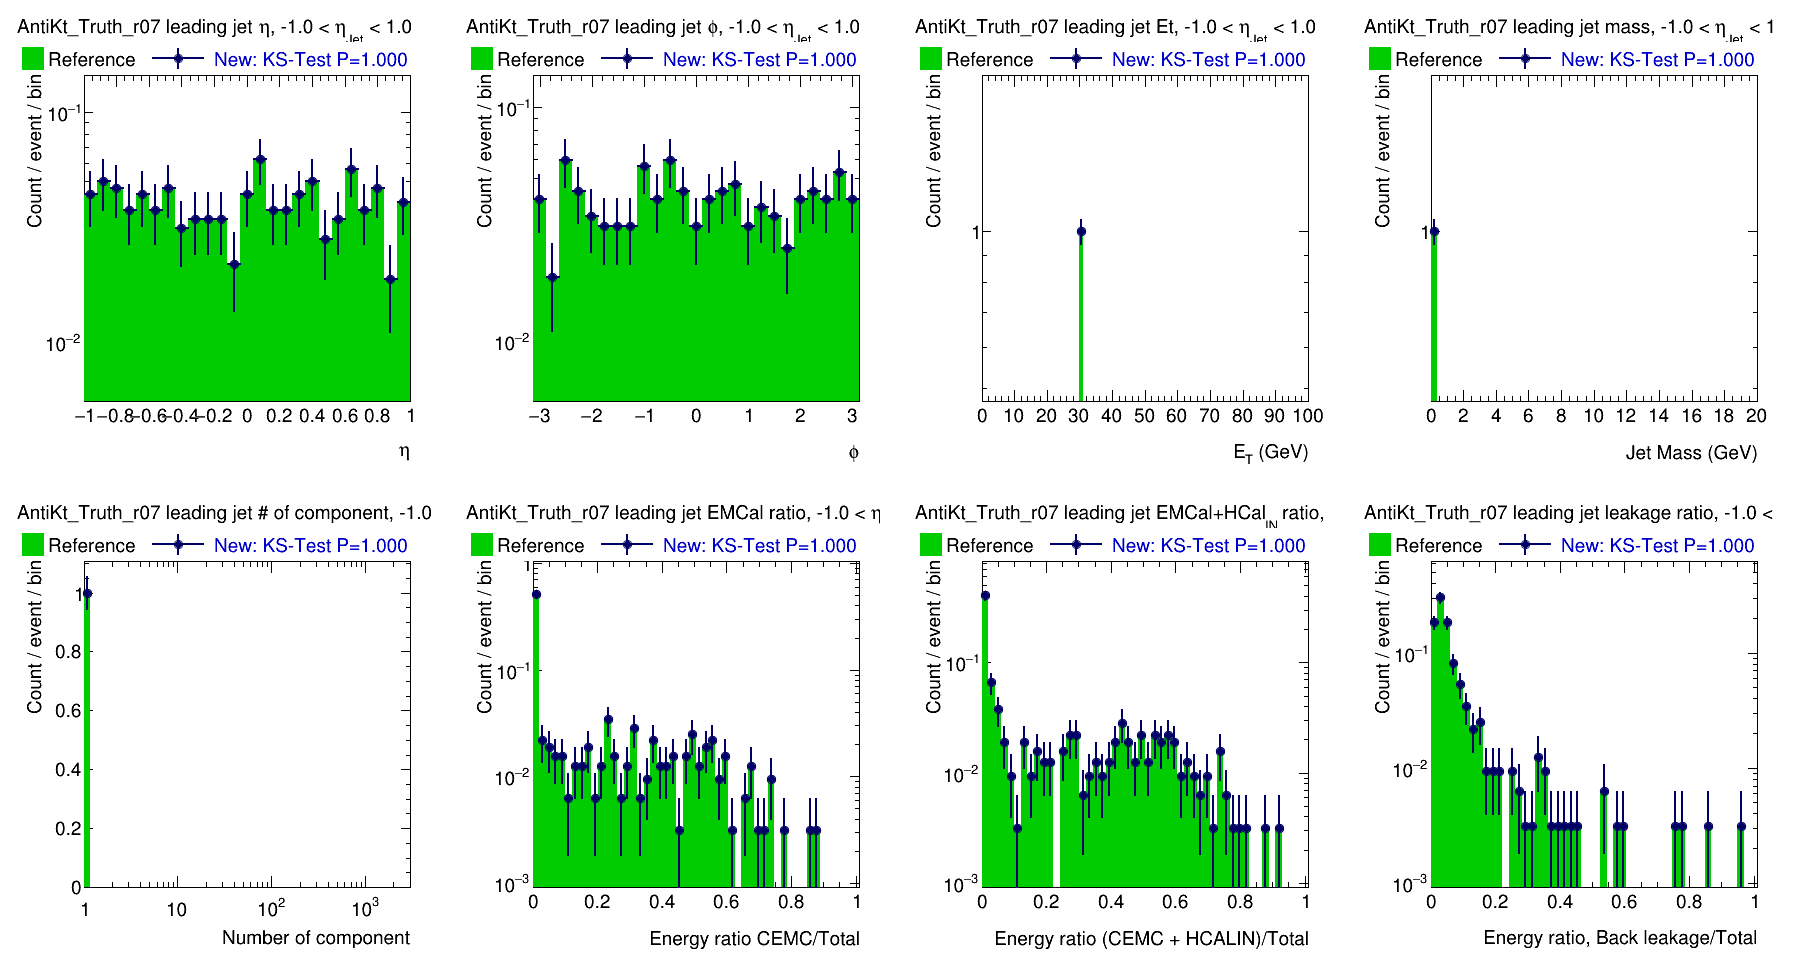

In [12]:
%%cpp

QA_Draw_Jet_Spectrum("h_QAG4SimJet_AntiKt_Truth_r07");


## Reco tower jet spectrum

Jet the details of the reco tower jet in response to this single particle

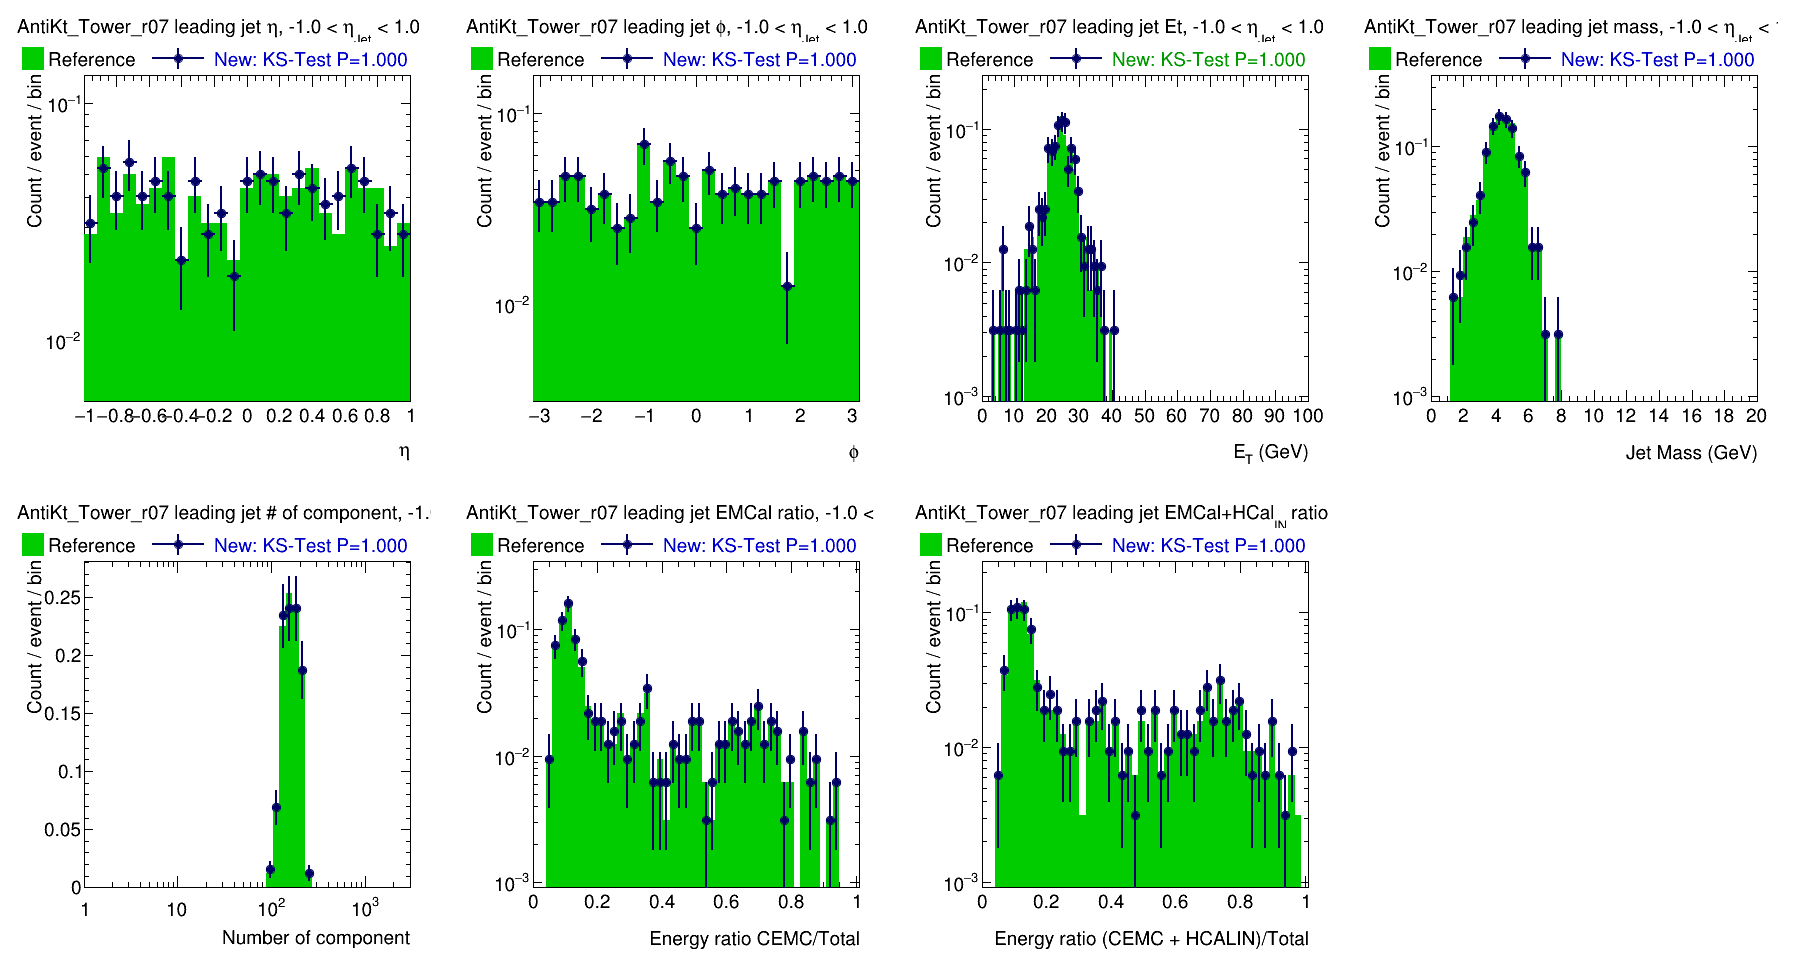

In [13]:
%%cpp

QA_Draw_Jet_Spectrum("h_QAG4SimJet_AntiKt_Tower_r07");


# Jet-Truth matching

Bunch of plots matching reco jet to truth jet

In [14]:
%%cpp

//! jet family, tower, cluster or track jets 
const char *jet_family = "AntiKt_Tower";

//! drawing energy range
const double min_Et = 10;
const double max_Et = 80;


In [15]:
%%cpp -d

// utility of drawing a matching pair

vector<TGraphErrors *>
QA_Draw_Jet_TruthMatching(const char *jet =
                              "h_QAG4SimJet_AntiKt_Truth_r07_AntiKt_Tower_r07")
{

  vector<TGraphErrors *> resolution_collections;

  TCanvas *c1 = new TCanvas(
      TString("QA_Draw_Jet_TruthMatching_") + TString(jet),
      TString("QA_Draw_Jet_TruthMatching_") + TString(jet), 1800, 900);
  c1->Divide(3, 2);
  int idx = 1;
  TPad *p;

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  {
    TH2F *proj_new = (TH2F *) qa_file_new->GetObjectChecked(
        TString(jet) + "_Matching_dPhi", "TH2F");

    assert(proj_new);

    proj_new->Rebin2D(1, 5);

    TGraphErrors *ge = FitProfile(proj_new);

    proj_new->GetXaxis()->SetRangeUser(min_Et, max_Et);
    proj_new->GetYaxis()->SetTitleOffset(1.5);
    proj_new->Draw("COLZ");

    TGraphErrors *ge_ref = NULL;
    if (qa_file_ref)
    {
      TH2F *proj_ref = (TH2F *) qa_file_ref->GetObjectChecked(
          TString(jet) + "_Matching_dPhi", "TH2F");
      assert(proj_ref);
      proj_ref->Rebin2D(1, 5);
      TGraphErrors *ge_ref = FitProfile(proj_ref);
    }
    DrawReference(ge, ge_ref);

    resolution_collections.push_back(ge);
  }
  TLine *l = new TLine(min_Et, 0, max_Et, 00);
  l->Draw();
    
  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  {
    TH2F *proj_new = (TH2F *) qa_file_new->GetObjectChecked(
        TString(jet) + "_Matching_dEta", "TH2F");

    assert(proj_new);

    proj_new->Rebin2D(1, 5);
    TGraphErrors *ge = FitProfile(proj_new);

    proj_new->GetXaxis()->SetRangeUser(min_Et, max_Et);
    proj_new->GetYaxis()->SetTitleOffset(1.5);
    proj_new->Draw("COLZ");
    proj_new->SetTitle(jet);

    TGraphErrors *ge_ref = NULL;
    if (qa_file_ref)
    {
      TH2F *proj_ref = (TH2F *) qa_file_ref->GetObjectChecked(
          TString(jet) + "_Matching_dEta", "TH2F");
      assert(proj_ref);
      proj_ref->Rebin2D(1, 5);
      TGraphErrors *ge_ref = FitProfile(proj_ref);
    }
    DrawReference(ge, ge_ref);

    resolution_collections.push_back(ge);
  }
  l = new TLine(min_Et, 0, max_Et, 00);
  l->Draw();

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  {
    TH2F *proj_new = (TH2F *) qa_file_new->GetObjectChecked(
        TString(jet) + "_Matching_dE", "TH2F");

    assert(proj_new);

    //    proj_new->Rebin2D(1,5);

    TGraphErrors *ge = FitProfile(proj_new);

    proj_new->GetXaxis()->SetRangeUser(min_Et, max_Et);
    proj_new->GetYaxis()->SetTitleOffset(1.5);
    proj_new->Draw("COLZ");
    proj_new->SetTitle(jet);

    TGraphErrors *ge_ref = NULL;
    if (qa_file_ref)
    {
      TH2F *proj_ref = (TH2F *) qa_file_ref->GetObjectChecked(
          TString(jet) + "_Matching_dE", "TH2F");
      assert(proj_ref);
      proj_ref->Rebin2D(1, 5);
      TGraphErrors *ge_ref = FitProfile(proj_ref);
    }
    DrawReference(ge, ge_ref);

    resolution_collections.push_back(ge);
  }
  l = new TLine(min_Et, 1, max_Et, 1);
  l->Draw();

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  {
    TH2F *proj_new = (TH2F *) qa_file_new->GetObjectChecked(
        TString(jet) + "_Matching_dEt", "TH2F");

    assert(proj_new);

    //    proj_new->Rebin2D(1,5);
    TGraphErrors *ge = FitProfile(proj_new);

    proj_new->GetXaxis()->SetRangeUser(min_Et, max_Et);
    proj_new->GetYaxis()->SetTitleOffset(1.5);
    proj_new->Draw("COLZ");
    proj_new->SetTitle(jet);

    TGraphErrors *ge_ref = NULL;
    if (qa_file_ref)
    {
      TH2F *proj_ref = (TH2F *) qa_file_ref->GetObjectChecked(
          TString(jet) + "_Matching_dEt", "TH2F");
      assert(proj_ref);
      proj_ref->Rebin2D(1, 5);
      TGraphErrors *ge_ref = FitProfile(proj_ref);
    }
    DrawReference(ge, ge_ref);

    resolution_collections.push_back(ge);
  }
  l = new TLine(min_Et, 1, max_Et, 1);
  l->Draw();

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  {
    TH2F *h2 = (TH2F *) qa_file_new->GetObjectChecked(
        TString(jet) + "_Matching_Count_Truth_Et", "TH2F");
    assert(h2);

    TH1 *h_norm = h2->ProjectionX(
        TString(jet) + "_Matching_Count_Truth_Et" + "_All", 1, 1);
    //          TH1 * h_pass = h2->ProjectionX(
    //              TString(jet) + "_Matching_Count_Truth_Et" + "_Matched", 2, 2);// inclusive match
    TH1 *h_pass = h2->ProjectionX(
        TString(jet) + "_Matching_Count_Truth_Et" + "_Matched", 3, 3);  // unique match
    assert(h_norm);
    assert(h_pass);
    TH1 *h_ratio = GetBinominalRatio(h_pass, h_norm);

    h_ratio->GetXaxis()->SetRangeUser(min_Et, max_Et);
    h_ratio->GetYaxis()->SetTitle("Reco efficiency");
    h_ratio->GetYaxis()->SetRangeUser(-0, 1.2);

    TH1 *h_ratio_ref = NULL;
    if (qa_file_ref)
    {
      TH2F *h2 = (TH2F *) qa_file_ref->GetObjectChecked(
          TString(jet) + "_Matching_Count_Truth_Et", "TH2F");
      assert(h2);
      TH1 *h_norm = h2->ProjectionX(
          TString(jet) + "_Matching_Count_Truth_Et" + "_All", 1, 1);
      //          TH1 * h_pass = h2->ProjectionX(
      //              TString(jet) + "_Matching_Count_Truth_Et" + "_Matched", 2, 2);// inclusive match
      TH1 *h_pass = h2->ProjectionX(
          TString(jet) + "_Matching_Count_Truth_Et" + "_Matched", 3, 3);  // unique match
      assert(h_norm);
      assert(h_pass);
      h_ratio_ref = GetBinominalRatio(h_pass, h_norm);
    }

    DrawReference(h_ratio, h_ratio_ref, true);

    resolution_collections.push_back(new TGraphErrors(h_ratio));
  }

  l = new TLine(min_Et, 1, max_Et, 1);
  l->Draw();

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  {
    TH2F *h2 = (TH2F *) qa_file_new->GetObjectChecked(
        TString(jet) + "_Matching_Count_Reco_Et", "TH2F");
    assert(h2);

    TH1 *h_norm = h2->ProjectionX(
        TString(jet) + "_Matching_Count_Reco_Et" + "_All", 1, 1);
    //      TH1 * h_pass = h2->ProjectionX(
    //          TString(jet) + "_Matching_Count_Reco_Et" + "_Matched", 2, 2); // inclusive match
    TH1 *h_pass = h2->ProjectionX(
        TString(jet) + "_Matching_Count_Reco_Et" + "_Matched", 3, 3);  // unique match
    assert(h_norm);
    assert(h_pass);
    TH1 *h_ratio = GetBinominalRatio(h_pass, h_norm);

    h_ratio->GetXaxis()->SetRangeUser(min_Et, max_Et);
    h_ratio->GetYaxis()->SetTitle("Reconstruction Purity");
    h_ratio->GetYaxis()->SetRangeUser(-0, 1.2);

    TH1 *h_ratio_ref = NULL;
    if (qa_file_ref)
    {
      TH2F *h2 = (TH2F *) qa_file_ref->GetObjectChecked(
          TString(jet) + "_Matching_Count_Reco_Et", "TH2F");
      assert(h2);

      TH1 *h_norm = h2->ProjectionX(
          TString(jet) + "_Matching_Count_Reco_Et" + "_All", 1, 1);
      //      TH1 * h_pass = h2->ProjectionX(
      //          TString(jet) + "_Matching_Count_Reco_Et" + "_Matched", 2, 2); // inclusive match
      TH1 *h_pass = h2->ProjectionX(
          TString(jet) + "_Matching_Count_Reco_Et" + "_Matched", 3, 3);  // unique match
      assert(h_norm);
      assert(h_pass);
      h_ratio_ref = GetBinominalRatio(h_pass, h_norm);
    }

    DrawReference(h_ratio, h_ratio_ref, true);

    resolution_collections.push_back(new TGraphErrors(h_ratio));
  }

  l = new TLine(min_Et, 1, max_Et, 1);
  l->Draw();

//  PutInputFileName(c1, .04, qa_file_name_new, qa_file_name_ref);
    c1->Draw();
  //SaveCanvas(c1, TString(qa_file_name_new) + TString(c1->GetName()), false);
    
  return resolution_collections;
}

In [16]:
%%cpp
{
//      qa_file_new->GetListOfKeys().Print()
//     qa_file_new->ls();
//    QA_Draw_Jet_TruthMatching("h_QAG4SimJet_AntiKt_Truth_r07_AntiKt_Tower_r07");

}

## Kinematic dependent Jet matching plots for various radius

Seraching for jet pairs in 418 QA histograms with pattern h_QAG4SimJet_.*_r[0-9]*_AntiKt_Tower_r[0-9]*_Matching_Count_Truth_Et
QA_Draw_Jet_Summary - process jet pair h_QAG4SimJet_AntiKt_Truth_r02_AntiKt_Tower_r02 with radius = 0.2
QA_Draw_Jet_Summary - process jet pair h_QAG4SimJet_AntiKt_Truth_r04_AntiKt_Tower_r04 with radius = 0.4
QA_Draw_Jet_Summary - process jet pair h_QAG4SimJet_AntiKt_Truth_r07_AntiKt_Tower_r07 with radius = 0.7


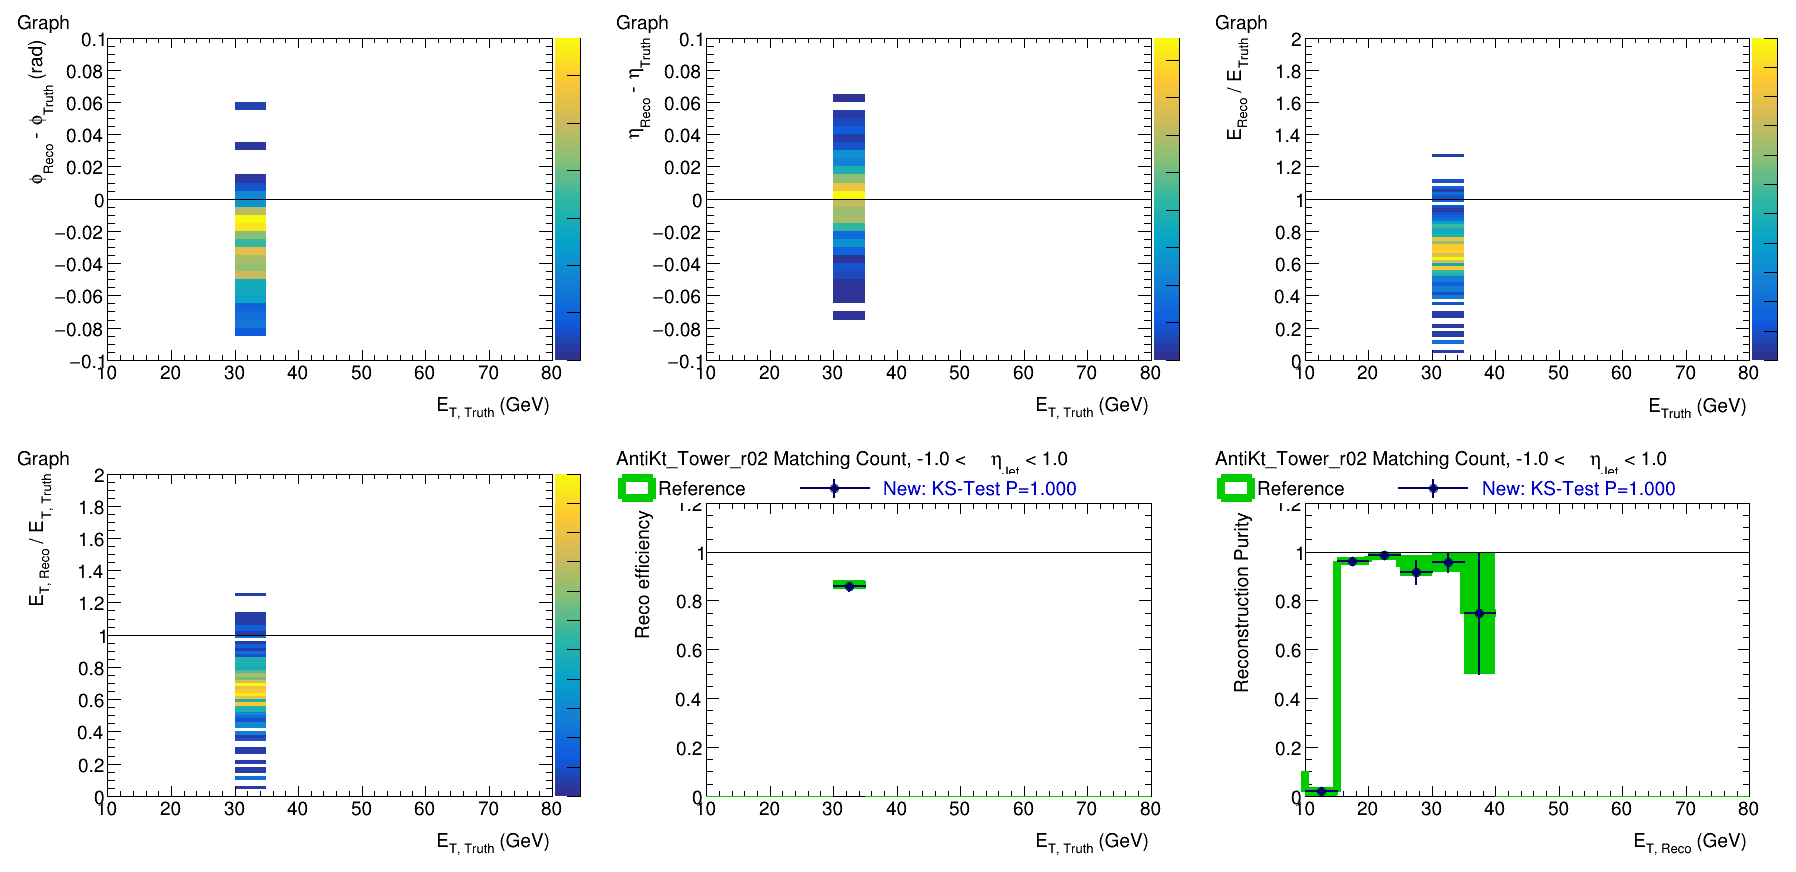

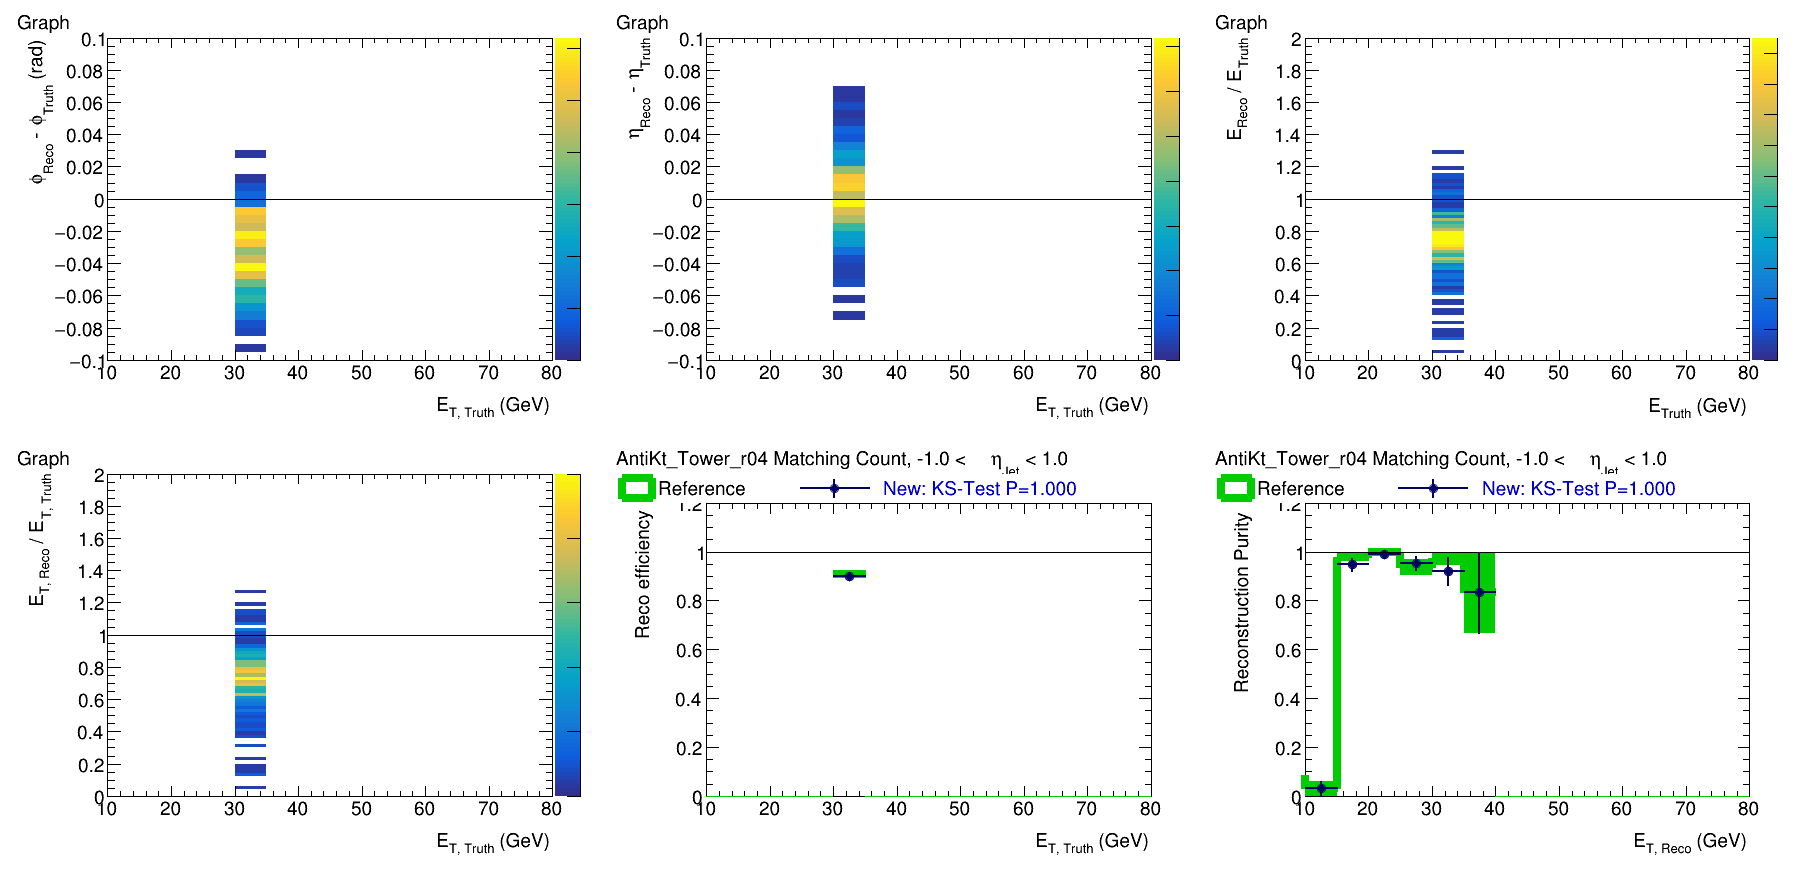

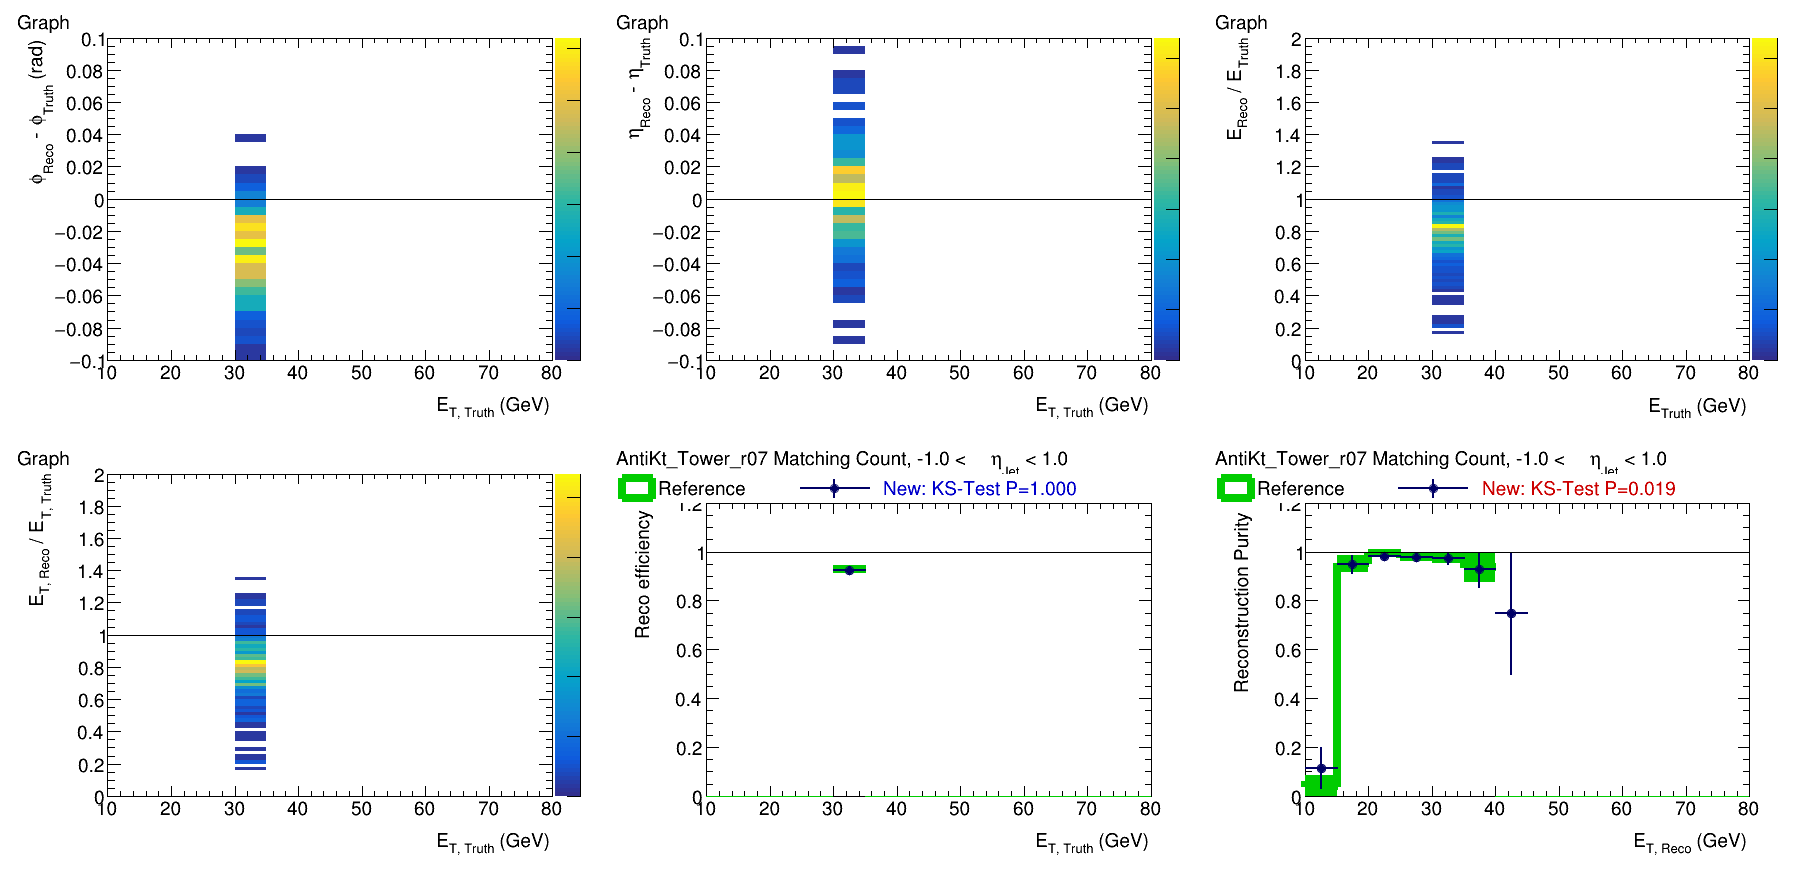

In [17]:
%%cpp

// buffer for results
vector<float> vec_radius;
vector<TGraphErrors *> vec_phi_res;
vector<TGraphErrors *> vec_eta_res;
vector<TGraphErrors *> vec_e_res;
vector<TGraphErrors *> vec_et_res;
vector<TGraphErrors *> vec_reco_eff;
vector<TGraphErrors *> vec_purity;

{
    
  // list and process all jets
  TList *hist_key_list = qa_file_new->GetListOfKeys();
    TString s_re_fullname = Form(
        "h_QAG4SimJet_.*_r[0-9]*_%s_r[0-9]*_Matching_Count_Truth_Et",
        jet_family);  // regular expression for search
    TRegexp re_fullname(s_re_fullname, false);
    
  cout <<"Seraching for jet pairs in "<<hist_key_list->GetSize()<<" QA histograms with pattern "<<s_re_fullname<<endl;
  for (int i = 0; i < hist_key_list->GetSize(); ++i)
  {
    TString key_name = hist_key_list->At(i)->GetName();

    if (key_name.Index(re_fullname) == kNPOS)
      continue;

    //      cout << " key_name = " << key_name << endl;
    TString jet_pair_name = key_name(0,
                                     key_name.Length() - TString("_Matching_Count_Truth_Et").Length());  // remove suffix

    // cout << "Processing jet_pair_name = " << jet_pair_name << endl;

    //get jet radius
    TRegexp re_jetradius("_r[0-9]*", false);
    Ssiz_t index_radius = key_name.Index(re_jetradius);             // first radius
    index_radius = key_name.Index(re_jetradius, index_radius + 1);  // second radius
    assert(index_radius != kNPOS);
    float radius = 0;
    sscanf(key_name(index_radius, 100).Data(), "_r%f", &radius);
    //      cout << " index_radius = " << index_radius << endl;
    assert(radius != 0);
    radius /= 10;  // jet radius convention in DST names

    cout << "QA_Draw_Jet_Summary - process jet pair " << jet_pair_name
         << " with radius = " << radius << endl;

    vector<TGraphErrors *> resolution_efficiency_summary(
        QA_Draw_Jet_TruthMatching(jet_pair_name));

    //save results
    vec_radius.push_back(radius);
    vec_phi_res.push_back(resolution_efficiency_summary[0]);
    vec_eta_res.push_back(resolution_efficiency_summary[1]);
    vec_e_res.push_back(resolution_efficiency_summary[2]);
    vec_et_res.push_back(resolution_efficiency_summary[3]);
    vec_reco_eff.push_back(resolution_efficiency_summary[4]);
    vec_purity.push_back(resolution_efficiency_summary[5]);

  }
    
}

## Summary plot as function of jet parameter

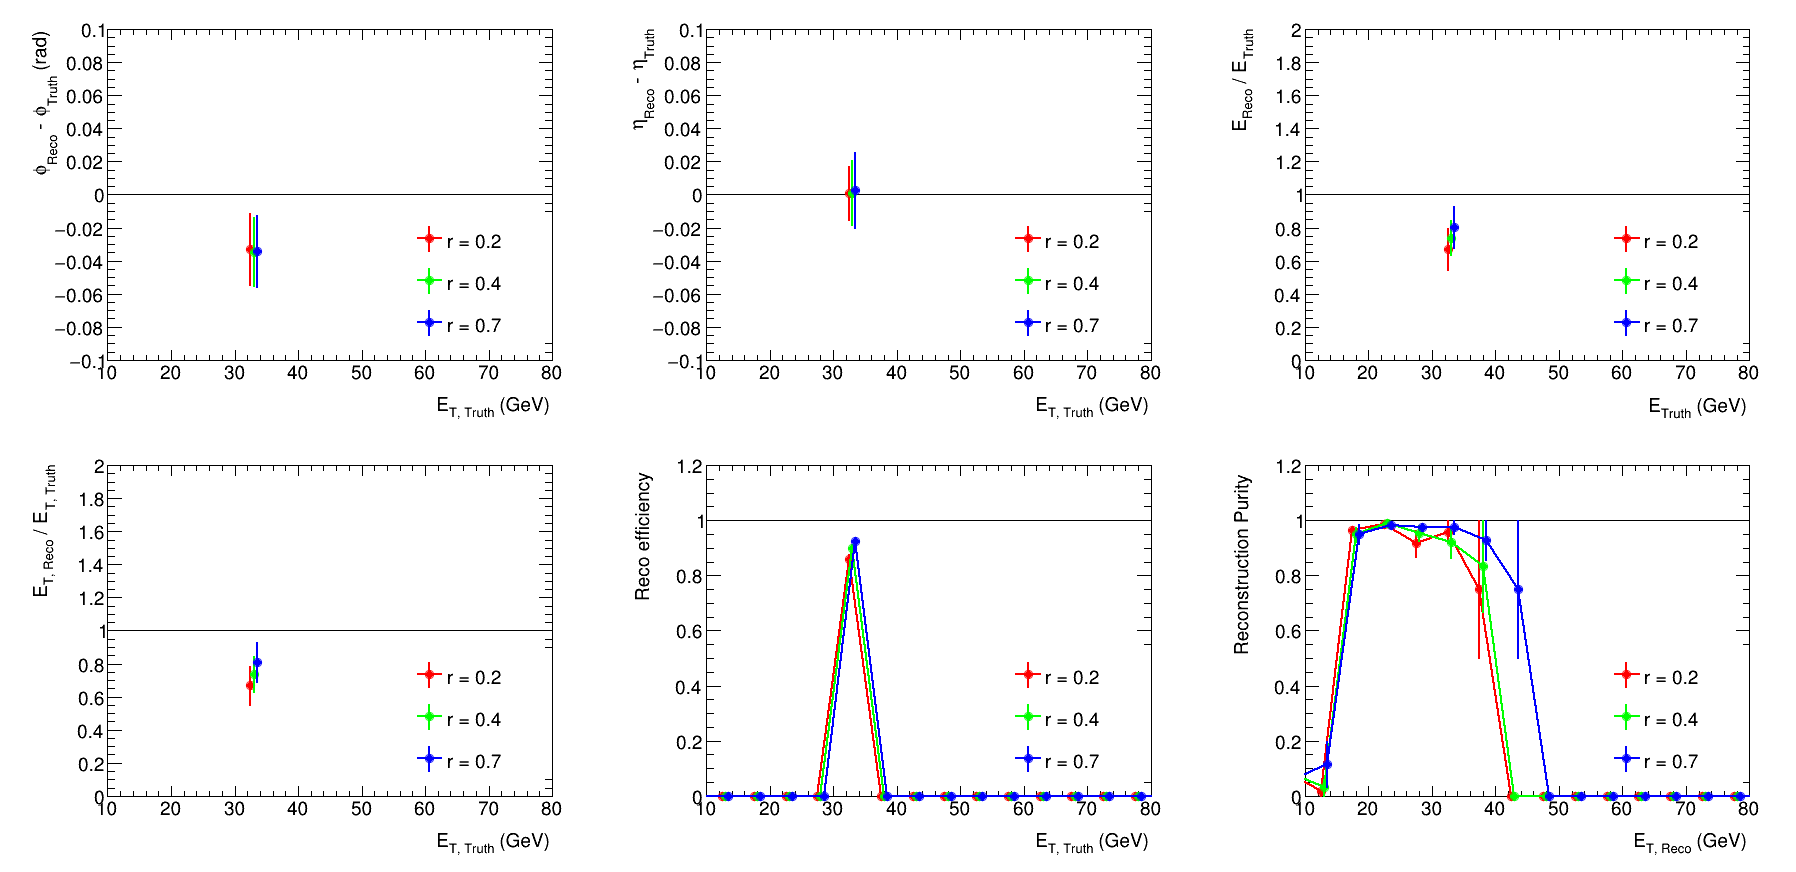

In [18]:
%%cpp

{
    
  // plot
  TCanvas *c1 = new TCanvas(
      TString("QA_Draw_Jet_Summary_") + TString(jet_family),
      TString("QA_Draw_Jet_Summary_") + TString(jet_family), 1800, 900);
  c1->Divide(3, 2);
  int idx = 1;
  TPad *p;

  // ------------------------------------
  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  TH1 *h_frame =
      p->DrawFrame(min_Et, -.1, max_Et, .1,
                   TString(jet_family) + " #phi Reconstruction;E_{T, Truth} (GeV);#phi_{Reco} - #phi_{Truth} (rad)");
  //  h_frame->GetYaxis()->SetTitleOffset(1.01);
  TLine *l = new TLine(min_Et, 0, max_Et, 0);
  l->Draw();
  p->SetGridx(0);
  p->SetGridy(0);
  TLegend *legend = new TLegend(0.7, 0.2, .95, 0.5);
  legend->SetFillColor(kWhite);
  legend->SetFillStyle(1001);
  legend->SetLineWidth(2);
  legend->SetLineColor(kBlack);
  legend->SetLineStyle(kSolid);
  for (int i = 0; i < vec_radius.size(); ++i)
  {
    const float radius = vec_radius[i];

    TGraphErrors *ge = vec_phi_res[i];
    assert(ge);
    ge = new TGraphErrors(*ge);  // make a copy

    ge->SetLineColor(i + 2);    // automatic color scheme from ROOT
    ge->SetMarkerColor(i + 2);  // automatic color scheme from ROOT
    for (int idata = 0; idata < ge->GetN(); ++idata)
    {
      (ge->GetX())[idata] += i * 0.5;  // shift x a little bit
      (ge->GetEX())[idata] = 0;        // no x error bar
    }
    ge->Draw("p E l");
    legend->AddEntry(ge, Form("r = %.1f", radius), "elp");
  }
  legend->Draw();

  // ------------------------------------
  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  h_frame =
      p->DrawFrame(min_Et, -.1, max_Et, .1,
                   TString(jet_family) + " #eta Reconstruction;E_{T, Truth} (GeV);#eta_{Reco} - #eta_{Truth}");
  //  h_frame->GetYaxis()->SetTitleOffset(1.01);
  l = new TLine(min_Et, 0, max_Et, 0);
  l->Draw();
  p->SetGridx(0);
  p->SetGridy(0);
  legend = new TLegend(0.7, 0.2, .95, 0.5);
  legend->SetFillColor(kWhite);
  legend->SetFillStyle(1001);
  legend->SetLineWidth(2);
  legend->SetLineColor(kBlack);
  legend->SetLineStyle(kSolid);
  for (int i = 0; i < vec_radius.size(); ++i)
  {
    const float radius = vec_radius[i];

    TGraphErrors *ge = vec_eta_res[i];
    assert(ge);
    ge = new TGraphErrors(*ge);  // make a copy

    ge->SetLineColor(i + 2);    // automatic color scheme from ROOT
    ge->SetMarkerColor(i + 2);  // automatic color scheme from ROOT
    for (int idata = 0; idata < ge->GetN(); ++idata)
    {
      (ge->GetX())[idata] += i * 0.5;  // shift x a little bit
      (ge->GetEX())[idata] = 0;        // no x error bar
    }
    ge->Draw("p E l");
    legend->AddEntry(ge, Form("r = %.1f", radius), "elp");
  }
  legend->Draw();

  // ------------------------------------
  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  h_frame = p->DrawFrame(min_Et, 0, max_Et, 2,
                         TString(jet_family) + " Jet Energy Reconstruction;E_{Truth} (GeV);E_{Reco} / E_{Truth}");
  //  h_frame->GetYaxis()->SetTitleOffset(1.01);
  l = new TLine(min_Et, 1, max_Et, 1);
  l->Draw();
  p->SetGridx(0);
  p->SetGridy(0);
  legend = new TLegend(0.7, 0.2, .95, 0.5);
  legend->SetFillColor(kWhite);
  legend->SetFillStyle(1001);
  legend->SetLineWidth(2);
  legend->SetLineColor(kBlack);
  legend->SetLineStyle(kSolid);
  for (int i = 0; i < vec_radius.size(); ++i)
  {
    const float radius = vec_radius[i];

    TGraphErrors *ge = vec_e_res[i];
    assert(ge);
    ge = new TGraphErrors(*ge);  // make a copy

    ge->SetLineColor(i + 2);    // automatic color scheme from ROOT
    ge->SetMarkerColor(i + 2);  // automatic color scheme from ROOT
    for (int idata = 0; idata < ge->GetN(); ++idata)
    {
      (ge->GetX())[idata] += i * 0.5;  // shift x a little bit
      (ge->GetEX())[idata] = 0;        // no x error bar
    }
    ge->Draw("p E l");
    legend->AddEntry(ge, Form("r = %.1f", radius), "elp");
  }
  legend->Draw();

  // ------------------------------------
  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  h_frame =
      p->DrawFrame(min_Et, 0, max_Et, 2,
                   TString(jet_family) + " Jet E_{T} Reconstruction;E_{T, Truth} (GeV);E_{T, Reco} / E_{T, Truth}");
  //  h_frame->GetYaxis()->SetTitleOffset(1.01);
  l = new TLine(min_Et, 1, max_Et, 1);
  l->Draw();
  p->SetGridx(0);
  p->SetGridy(0);
  legend = new TLegend(0.7, 0.2, .95, 0.5);
  legend->SetFillColor(kWhite);
  legend->SetFillStyle(1001);
  legend->SetLineWidth(2);
  legend->SetLineColor(kBlack);
  legend->SetLineStyle(kSolid);
  for (int i = 0; i < vec_radius.size(); ++i)
  {
    const float radius = vec_radius[i];

    TGraphErrors *ge = vec_et_res[i];
    assert(ge);
    ge = new TGraphErrors(*ge);  // make a copy

    ge->SetLineColor(i + 2);    // automatic color scheme from ROOT
    ge->SetMarkerColor(i + 2);  // automatic color scheme from ROOT
    for (int idata = 0; idata < ge->GetN(); ++idata)
    {
      (ge->GetX())[idata] += i * 0.5;  // shift x a little bit
      (ge->GetEX())[idata] = 0;        // no x error bar
    }
    ge->Draw("p E l");
    legend->AddEntry(ge, Form("r = %.1f", radius), "elp");
  }
  legend->Draw();

  // ------------------------------------
  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  h_frame = p->DrawFrame(min_Et, 0, max_Et, 1.2,
                         TString(jet_family) + " Reco Efficiency;E_{T, Truth} (GeV);Reco efficiency");
  //  h_frame->GetYaxis()->SetTitleOffset(1.01);
  l = new TLine(min_Et, 1, max_Et, 1);
  l->Draw();
  p->SetGridx(0);
  p->SetGridy(0);
  legend = new TLegend(0.7, 0.2, .95, 0.5);
  legend->SetFillColor(kWhite);
  legend->SetFillStyle(1001);
  legend->SetLineWidth(2);
  legend->SetLineColor(kBlack);
  legend->SetLineStyle(kSolid);
  for (int i = 0; i < vec_radius.size(); ++i)
  {
    const float radius = vec_radius[i];

    TGraphErrors *ge = vec_reco_eff[i];
    assert(ge);
    ge = new TGraphErrors(*ge);  // make a copy

    ge->SetLineColor(i + 2);    // automatic color scheme from ROOT
    ge->SetMarkerColor(i + 2);  // automatic color scheme from ROOT
    for (int idata = 0; idata < ge->GetN(); ++idata)
    {
      (ge->GetX())[idata] += i * 0.5;  // shift x a little bit
      (ge->GetEX())[idata] = 0;        // no x error bar
    }
    ge->Draw("p E l");
    legend->AddEntry(ge, Form("r = %.1f", radius), "elp");
  }
  legend->Draw();

  // ------------------------------------
  p = (TPad *) c1->cd(idx++);
  c1->Update();
  //  p->SetLogz();

  h_frame = p->DrawFrame(min_Et, 0, max_Et, 1.2,
                         TString(jet_family) + " Reconstruction Purity;E_{T, Reco} (GeV);Reconstruction Purity");
  //  h_frame->GetYaxis()->SetTitleOffset(1.01);
  l = new TLine(min_Et, 1, max_Et, 1);
  l->Draw();
  p->SetGridx(0);
  p->SetGridy(0);
  legend = new TLegend(0.7, 0.2, .95, 0.5);
  legend->SetFillColor(kWhite);
  legend->SetFillStyle(1001);
  legend->SetLineWidth(2);
  legend->SetLineColor(kBlack);
  legend->SetLineStyle(kSolid);
  for (int i = 0; i < vec_radius.size(); ++i)
  {
    const float radius = vec_radius[i];

    TGraphErrors *ge = vec_purity[i];
    assert(ge);
    ge = new TGraphErrors(*ge);  // make a copy

    ge->SetLineColor(i + 2);    // automatic color scheme from ROOT
    ge->SetMarkerColor(i + 2);  // automatic color scheme from ROOT
    for (int idata = 0; idata < ge->GetN(); ++idata)
    {
      (ge->GetX())[idata] += i * 0.5;  // shift x a little bit
      (ge->GetEX())[idata] = 0;        // no x error bar
    }
    ge->Draw("p E l");
    legend->AddEntry(ge, Form("r = %.1f", radius), "elp");
  }
  legend->Draw();

  //  PutInputFileName(c1, .03, qa_file_name_new, qa_file_name_ref);
    c1->Draw();
  //SaveCanvas(c1, TString(qa_file_name_new) + TString(c1->GetName()), true);

}

# Summary statistics

In [19]:
%%cpp

KSTestSummary::getInstance()->make_summary_txt("QA-calorimetric-jet.txt");

This notebook contains 21 KSTets: combined Chi2/nDoF = 7.91824 / 42, and combined __p-Value = 1__


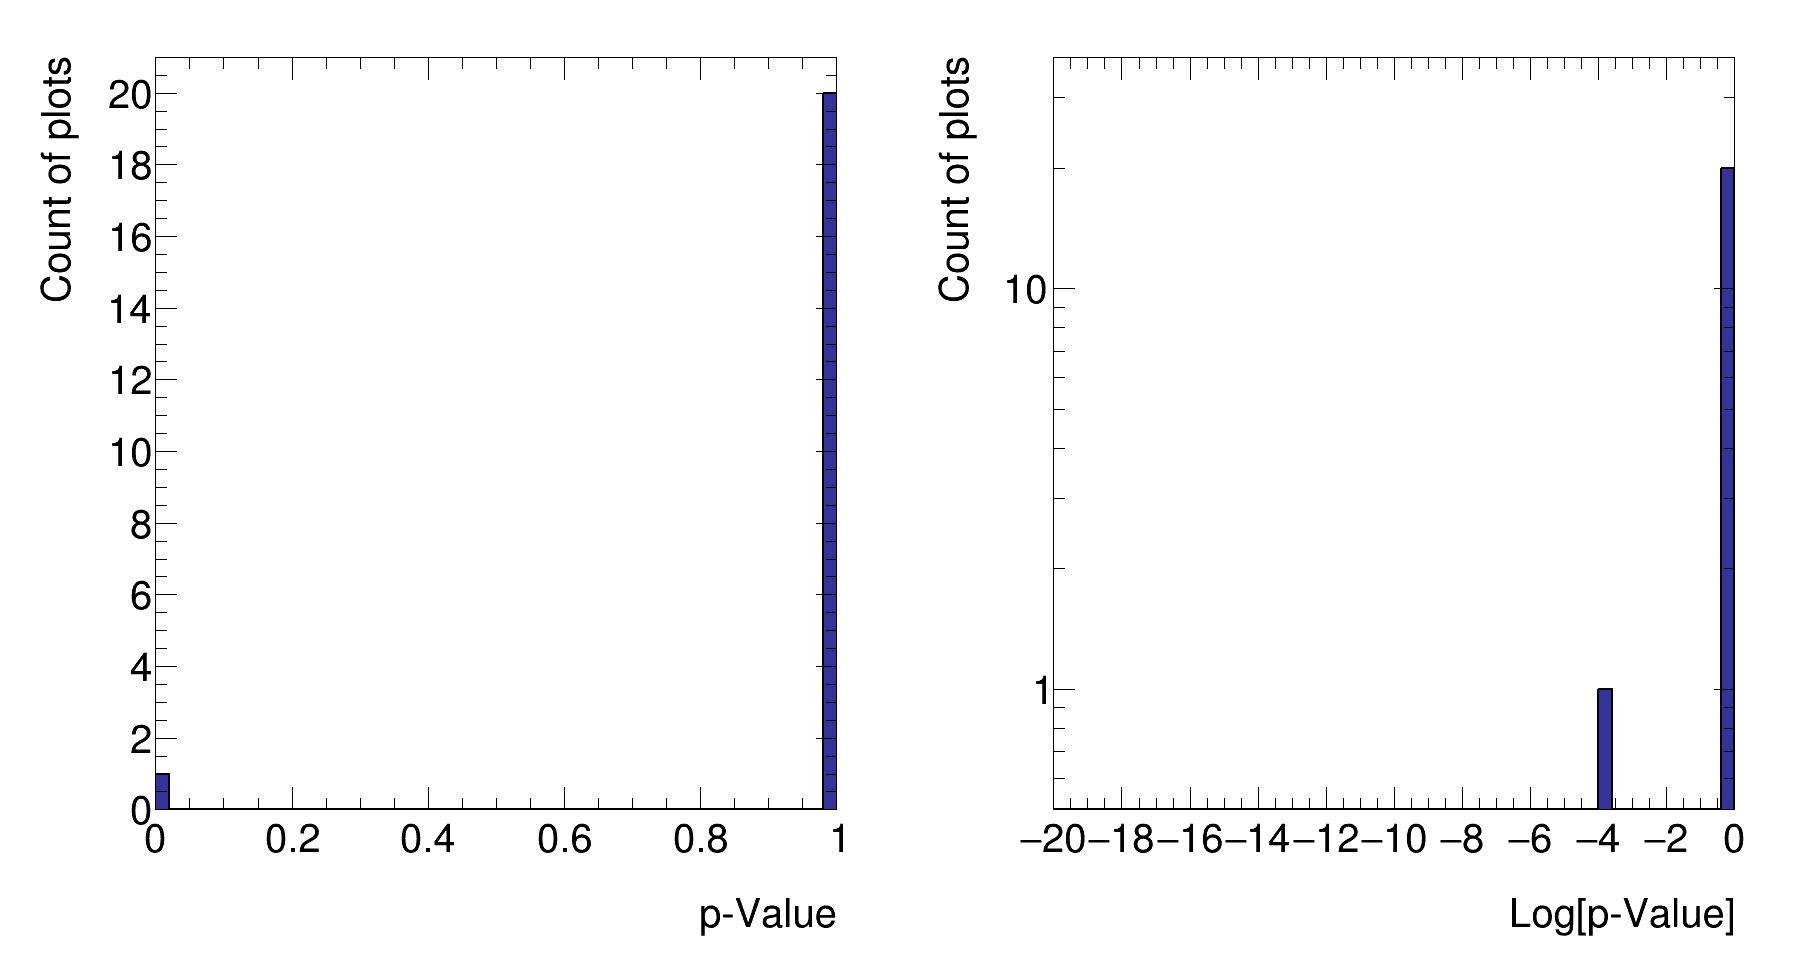

In [20]:
%%cpp

KSTestSummary::getInstance()->make_summary_TCanvas() -> Draw();